
@author : Romy (July 2022)

Useful Ressources : 
- https://nbviewer.org/github/NeuroanatomyAndConnectivity/gradient_analysis/blob/master/04_visualize_networks.ipynb
- https://github.com/MICA-MNI/BrainStat/blob/master/brainstat/context/resting.py

In [2]:
%matplotlib inline 

# !git clone https://github.com/margulies/gradient_analysis

import h5py, sys, io, os, numpy as np
import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting,surface
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

from brainspace.datasets import load_group_fc, load_parcellation, load_conte69



sys.path.append('/home/romy.beaute/projects/hypnomed/')
from helpers import imageCrop,load_embmat
# from helpers import *

In [3]:
templates_path = '/home/romy.beaute/projects/hypnomed/data/template' #path to cortex and yeo templates

output_path = '/home/romy.beaute/projects/hypnomed/analysis/scripts_stats/figures/yeo_networks/' #path to save figures

yeo_infos = pd.read_csv('/home/romy.beaute/projects/hypnomed/data/yeo_infos/7NetworksOrderedNames.csv',delimiter=',')
networks_labels = list(yeo_infos[' Network Name'])

colors = ['purple','blue','green','violet','cream','orange','red']
yeo_infos['colors']=colors 

yeo_infos

,Network Order,Network Name,colors
0,1,Visual,purple
1,2,Somatomotor,blue
2,3,Dorsal Attention,green
3,4,Salience / Ventral Attention,violet
4,5,Limbic,cream
5,6,Control,orange
6,7,Default,red


### Load fsaverage surfaces : cortical and yeo networks

In [4]:


#  CORTICAL SURFACES : Load Freesurfer fsaverage surface with read_label : return array with indices of vertices included in label
lab_lh = nib.freesurfer.read_label(templates_path+'/lh.cortex.label') #shape = (9361,)
lab_rh = 10242 + nib.freesurfer.read_label(templates_path+'/rh.cortex.label') #shape = (9361,)
lab= np.concatenate((lab_lh,lab_rh))
print('- Cortical shape : ',lab.shape)

# YEO NETWORKS SURFACES FROM FREESURFER
freesurfer_yeo_path = '/home/romy.beaute/projects/hypnomed/data/template/fsaverage/label'

yeo_l = surface.load_surf_data(os.path.join(freesurfer_yeo_path,'lh.Yeo2011_7Networks_N1000.annot'))
yeo_r = surface.load_surf_data(os.path.join(freesurfer_yeo_path,'rh.Yeo2011_7Networks_N1000.annot'))
yeo_freesurfer = np.hstack([yeo_l,yeo_r])
print('- Yeo surface shape : ',yeo_freesurfer.shape)

yeo7_freesurfer = np.concatenate((yeo_l[lab_lh], yeo_r[lab_rh]))
print('- Yeo (freesurfer) surface shape, after cortical mask : ',yeo7_freesurfer.shape)


- Cortical shape :  (18715,)
- Yeo surface shape :  (327684,)
- Yeo (freesurfer) surface shape, after cortical mask :  (18715,)


### Load pheno data

In [6]:
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_design_matrix


hypnomed_csv = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/hypnomed.csv')
hypnomed_csv_withoutliers = hypnomed_csv.query('outlier == 0')
hypnomed_csv_G1 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G1']
hypnomed_csv_G2 = hypnomed_csv_withoutliers.loc[hypnomed_csv_withoutliers['group']=='G2']


sublist_hypnomed = hypnomed_csv.query('outlier == 0')['sub_id'].tolist()
sublist_hypnomed_G1 = hypnomed_csv_G1['sub_id'].tolist()
sublist_hypnomed_G2 = hypnomed_csv_G2['sub_id'].tolist()
print('n = {} subjects in G1 / n = {} subjects in G2'.format(len(sublist_hypnomed_G1),len(sublist_hypnomed_G2)))



n_subjects = len(emb_sublist)
print('n subjects = ',n_subjects)
emb_sample = emb_sublist.tolist()

labels = np.concatenate([([i]*n_subjects) for i in ['control','meditation','hypnosis']],axis=0)
subjects = emb_sample*3
sub_groups = hypnomed_csv_withoutliers['group'].tolist()*3

behavioral_hypnomed = pd.DataFrame(data={'labels':labels,'subjects':subjects,'group':sub_groups})
behavioral_hypnomed

n = 18 subjects in G1 / n = 18 subjects in G2
n subjects =  36


,labels,subjects,group
0,control,sub-01,G2
1,control,sub-02,G1
2,control,sub-03,G1
3,control,sub-04,G1
4,control,sub-05,G2
...,...,...,...
103,hypnosis,sub-35,G2
104,hypnosis,sub-36,G1
105,hypnosis,sub-37,G2
106,hypnosis,sub-38,G2


###  Recreate the embedding design (data visualisation purpose)

We recall that the order of the "meta" embedding matrix* (grouping the different matrices for each block, for each participant) has been rearranged so as to display the embedding for each subject in the following order: "control", "meditation", "hypnosis", regardless of whether the subject did the "meditation" condition before or after the "hypnosis" condition (i.e. in block 2 or 3). The rearrangement is represented in the following design matrix : 

**matrix stored in : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat*

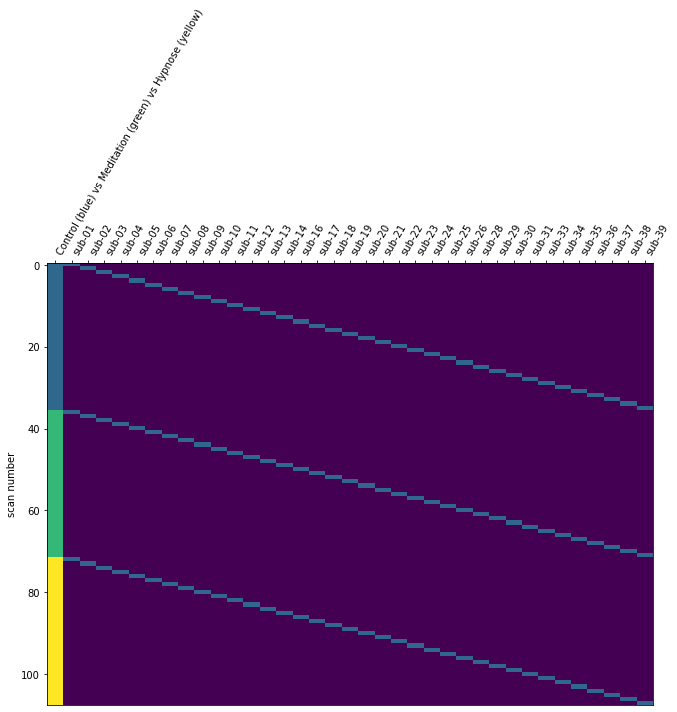

In [7]:
#Triple effect : control vs meditation vs hypnose
condition_effect_triple = np.hstack(([1] * n_subjects, [2] * n_subjects, [3] * n_subjects))
subject_effect_triple = np.vstack((np.eye(n_subjects), np.eye(n_subjects),np.eye(n_subjects)))
paired_design_matrix_triple = pd.DataFrame(
    np.hstack((condition_effect_triple[:, np.newaxis], subject_effect_triple)),
    columns=['Control (blue) vs Meditation (green) vs Hypnose (yellow)'] + emb_sample)


#_, (ax_paired) = plt.subplots(1,1, gridspec_kw={'width_ratios': [1, 17]})
plot_design_matrix(paired_design_matrix_triple, rescale=False)#, ax=ax_paired)
# ax_paired.set_title('paired design', fontsize=12)
# plt.set_title('paired design', fontsize=12)
plt.tight_layout()
plotting.show()

Therefore, we can conduct the analysis group by group to make sure that we are not looking at a block effet on the gradients.

In [62]:
hypnomed_quest = pd.read_csv('/home/romy.beaute/projects/hypnomed/analysis/pheno_stats/questionnaires_hypnomed.csv')

exclude_group = 'G2' #group to exclude : can be 'G1' (block 2 = meditation, block 3 = hypnose) or 'G2' (reverse order). If None, no group excluded, keep mixed order conditions
outliers_indxs = [15,27,32,40]
outliers_indxs_hyp = [15,27,39]


if exclude_group:
    print('Setting subject ids of group {} as outliers (exclusion)'.format(exclude_group))
    excluded_ids = hypnomed_quest.loc[hypnomed_quest['group']==exclude_group]['id'].tolist()

    outliers_indxs = np.unique([*excluded_ids,*outliers_indxs]).tolist()
    outliers_indxs_hyp = np.unique([*excluded_ids,*outliers_indxs_hyp]).tolist()

print('Excluding n = {} subjects (outliers + {})'.format(len(outliers_indxs),exclude_group))

Setting subject ids of group G2 as outliers (exclusion)
Excluding n = 22 subjects (outliers + G2)


### Load embeddings

In [66]:
# import sys
# sys.path.append('/home/romy.beaute/projects/hypnomed/META/')
# from scipy.io import loadmat
# from helpers_gradient import *

embmat_path = '/home/romy.beaute/projects/hypnomed/data/emb_matrices'
matfile = 'control_meditation_hypnose'
# emb = np.load(embmat_path+'/group_{}_embedding.mat'.format(matfile))

b,b_emb = load_embmat(embmat_path+'/group_{}_embedding.mat'.format(matfile),show_infos=True)
b_emb.shape


outliers = [x-1 for x in outliers_indxs] #redefining indexes wrt to python 
outliers_hyp = [x-1 for x in outliers_indxs_hyp]

emb_con = np.delete(b_emb[:40],outliers,0)
emb_med = np.delete(b_emb[40:80],outliers,0)
emb_hyp = np.delete(b_emb[80:],outliers_hyp,0)






print('Embedding shapes for the different states :\n - Embedding control : {}\n - Embedding meditation : {}\n - Embedding hypnosis : {}'.format(emb_con.shape,emb_med.shape,emb_hyp.shape))
embeddings = {
    'control':emb_con,
    'meditation':emb_med,
    'hypnose':emb_hyp
    }

emb_allstates = np.vstack([emb_con,emb_med,emb_hyp]) #embedding with all 3 states conditions
print(emb_allstates.shape) #control shape of the global embedding


emb_sublist = np.delete(b['subs'],[x-1 for x in outliers_indxs])
print('Redefining subject list after outlier removal : n_subjects = {} --> n_subjects = {}'.format(len(b['subs']),len(emb_sublist )))

 - shape embedding (n_subjects, n_voxels, n_dims): (119, 18715, 5)
 - n = 40 subjects
 - condition : ['control   ' 'meditation' 'hypnose   ']
 - path : /home/romy.beaute/projects/hypnomed/data/emb_matrices/group_control_meditation_hypnose_embedding.mat

Embedding shapes for the different states :
 - Embedding control : (18, 18715)
 - Embedding meditation : (18, 18715)
 - Embedding hypnosis : (18, 18715)
(54, 18715)
Redefining subject list after outlier removal : n_subjects = 40 --> n_subjects = 18


In [78]:
from PIL import Image
from IPython.display import Image as im

group = 'G2' if exclude_group == 'G1' else 'G1'


def plot_gradients_yeo(condition,group):

    a = np.zeros(20484)
    a[lab]=np.mean(embeddings[condition],axis=0)#average across subjects
    emb = a[lab]

    yeo7 = yeo7_freesurfer


    uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
    sz = len(uniqueY) #7 (corresponds to length network)
    rsns={}
    for c in range(sz): #creates dictionnary
        rsns['k'+str(int(c)+1)]=[]

    r = []     

    for x in range(sz):
        # g = emb[np.where(yeo7 == uniqueY[x]),0]
        g = emb[np.where(yeo7 == uniqueY[x])]
        # for y in g[0]:
        for y in g:
            if y != 0:
                rsns['k'+str(int(x)+1)].append(float(y))
        r.append(np.mean(rsns['k'+str(int(x)+1)]))

    ord = np.argsort(r)

    plot_list=[]
    for c in range(sz):    
        plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

    names=[]
    for c in range(sz):
        names.append(str(int(ord[c])+1))


#     # convertYeo7 = [2,5,6,0,4,1,3] 
    convertYeo7 = [0,1,2,3,4,5,6]
    # print(convertYeo7)

    cols7 = ((255,255,255),
            (120,  18, 134), #purple
            (70 ,130, 180), #blue
            ( 0 ,118 , 14), #green
            (196 , 58 ,250), #violet
            (220 ,248 ,164), #cream
            (230, 148,  34), #orange
            (205 , 62,  78 )) #red
    cols = cols7
    cols = np.asarray(cols, dtype=float)/255
    yeoCols = ListedColormap(cols,name='colormapYeo')
    # print(yeoCols)

    colors1 = list()
    for i in range(0,len(ord)):
        colors1.append(tuple(cols[convertYeo7[ord[i]] + 1]))

    height=10
    sns.set_context('notebook', font_scale=1.8)
    sns.axes_style("white")
    sns.set_style("white")
    sns.set_palette(colors1)



    fig = plt.figure(figsize=(20,height))
    ax = sns.boxplot(data=plot_list, saturation=0.5, orient='h', showfliers=False) #flierprops=None)#dict(marker='', markersize=0, 
                                                                                #color="white", markeredgecolor="white"))
    ax.set_yticklabels('')
    ax.set(xlabel='Gradient Values ({})\n n = {} subjects, group = {}'.format(condition,embeddings['control'].shape[0],group))
    # ax.set(ylabel=list(yeo_infos[' Network Name']))
    sns.axes_style("white")
    # sns.axlabel('Gradient Values','', fontsize=22)
    #ax.xlabel('Gradient Values','', fontsize=22)
    # plt.savefig('gradient_data/figures/yeo_dist_plot.pdf')
    # plt.savefig('gradient_data/figures/yeo_dist_plot.png')
    # plt.savefig(output_path+'yeo_dist_plot_{}.pdf'.format(condition))
    plt.savefig(output_path+'yeo_dist_plot_{}.png'.format(condition))
    plt.close(fig)

    fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(2*(20/sz),height))
    data = datasets.fetch_atlas_yeo_2011(data_dir='gradient_data/templates/')
    yeoV7 = nibabel.load(data.thick_7)
    y = 0

    for x in range(sz):
        yeoV7_1 = nibabel.Nifti1Image((yeoV7.get_fdata() == convertYeo7[ord[x]] + 1).astype(int), yeoV7.affine)     
        yeoCols = ListedColormap(cols[[0,convertYeo7[ord[x]] + 1]],name='colormapYeo')
        plotting.plot_glass_brain(yeoV7_1, axes=axarr[x], annotate=False, alpha=0.3, cmap=yeoCols, threshold=0.1, 
                            output_file=output_path+'yeo_brains_{}.png'.format(condition))
        y += 1


    i1 = Image.open(output_path+'yeo_dist_plot_{}.png'.format(condition))
    i2 = Image.open(output_path+'yeo_brains_{}.png'.format(condition))
    result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))
    result.paste(i1, (120, 0))
    result.paste(i2, (0, 0))
    result.save(output_path+'Yeo7_{}.png'.format(condition))
    os.remove(output_path+'yeo_dist_plot_{}.png'.format(condition))
    os.remove(output_path+'yeo_brains_{}.png'.format(condition))
    if group:
        filename=output_path+'Yeo7_{}_{}.png'.format(condition)
    else:
        filename=output_path+'Yeo7_{}.png'.format(condition)

    return im(filename)



### Mean gradients for Control condition

In [79]:
plot_gradients_yeo('control',group=group)

IndexError: Replacement index 1 out of range for positional args tuple

### Mean gradients for Meditation condition

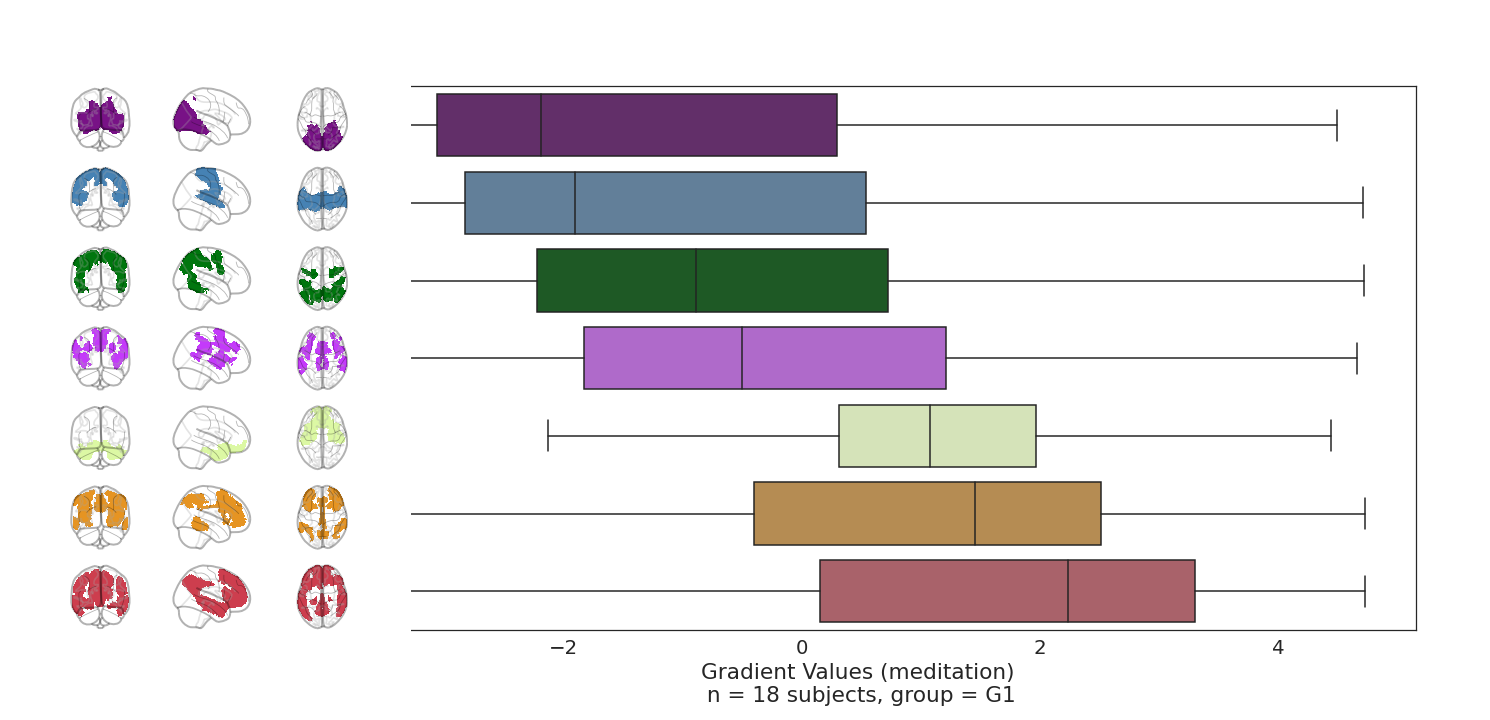

In [ ]:
plot_gradients_yeo('meditation',group=group)

### Mean gradients for Hypnose condition

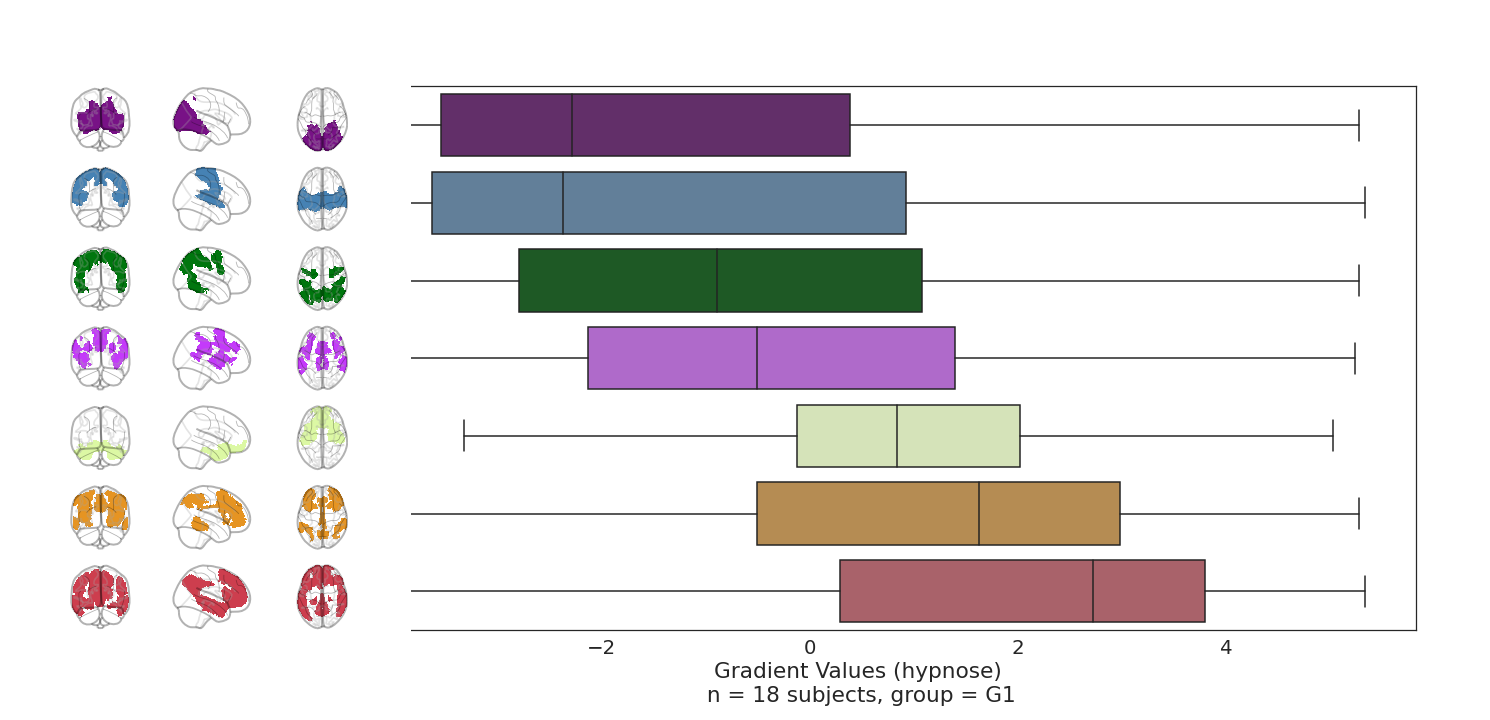

In [ ]:
plot_gradients_yeo('hypnose',group=group)

In [13]:
yeo_infos

,Network Order,Network Name,colors
0,1,Visual,purple
1,2,Somatomotor,blue
2,3,Dorsal Attention,green
3,4,Salience / Ventral Attention,violet
4,5,Limbic,cream
5,6,Control,orange
6,7,Default,red
